In [97]:
from scipy.io import mmread
import networkx as nx
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [98]:
ROOT_FOLDER = Path("..")
DATA_FOLDER = ROOT_FOLDER / "data"
OUTPUT_FOLDER = ROOT_FOLDER / "out"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [99]:
matrix = mmread(DATA_FOLDER / "econ-poli-large.mtx")
G = nx.DiGraph()

In [100]:
rows, cols, data = matrix.row, matrix.col, matrix.data

In [102]:
for source, target, weight in zip(rows, cols, data):
    G.add_edge(source + 1, target + 1, weight=weight)

In [103]:
nx.write_gexf(G, path=OUTPUT_FOLDER / "project.gexf")

In [114]:
df = pd.read_csv(DATA_FOLDER / "Project.csv")
df.head()

,Id,Label,indegree,outdegree,Degree,eigencentrality,clustering,modularity_class,stat_inf_class,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,componentnumber,strongcompnum
0,1,1,1,145,146,0.005391,0.009052,0,35,1.0000,-66.63240,-65.63240,11,0.139220,0.161498,0.000000,0,15465
1,2,2,4,4,8,0.108882,0.190476,1,0,0.0000,-0.09800,-0.09800,5,0.378486,0.414386,4632.833333,0,11457
2,1761,1761,2,188,190,0.171701,0.006855,2,27,0.9497,-124.02205,-123.07235,10,0.227935,0.267383,101354.921429,0,15053
3,7097,7097,4,20,24,0.092854,0.051383,3,0,0.1734,-11.55560,-11.38220,6,0.341317,0.404605,10605.850000,0,11458
4,3,3,5,35,40,0.093512,0.027665,4,0,-0.0000,-29.06400,-29.06400,1,1.000000,1.000000,3570.000000,0,11456


In [115]:
df.columns

Index(['Id', 'Label', 'indegree', 'outdegree', 'Degree', 'eigencentrality',
       'clustering', 'modularity_class', 'stat_inf_class', 'weighted indegree',
       'weighted outdegree', 'Weighted Degree', 'Eccentricity',
       'closnesscentrality', 'harmonicclosnesscentrality',
       'betweenesscentrality', 'componentnumber', 'strongcompnum'],
      dtype='object')

In [109]:
num_nodes = len(G.nodes)
num_edges = len(G.edges)
num_edges / (num_nodes * (num_nodes - 1))

0.00013635105304741964

Průměrný shlukovací koeficient (CC): 0.456


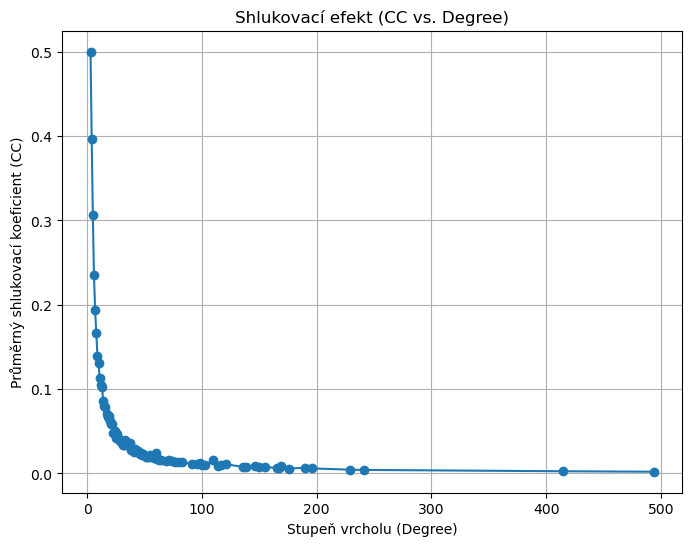

In [112]:
average_clustering_coefficient = df['clustering'].mean()
print(f"Průměrný shlukovací koeficient (CC): {average_clustering_coefficient:.3f}")

# Shlukovací efekt - průměrný CC pro vrcholy daného stupně
degree_clustering = df.groupby('Degree')['clustering'].mean()

# Vizualizace shlukovacího efektu
plt.figure(figsize=(8, 6))
plt.plot(degree_clustering.index, degree_clustering.values, marker='o', linestyle='-')
plt.xlabel('Stupeň vrcholu (Degree)')
plt.ylabel('Průměrný shlukovací koeficient (CC)')
plt.title('Shlukovací efekt (CC vs. Degree)')
plt.grid()
plt.show()

Počet souvislých komponent: 15466
Distribuce velikostí komponent:
strongcompnum
15053    90
4034      4
11878     4
11458     3
4861      2
         ..
20        1
19        1
18        1
17        1
15440     1
Name: count, Length: 15466, dtype: int64


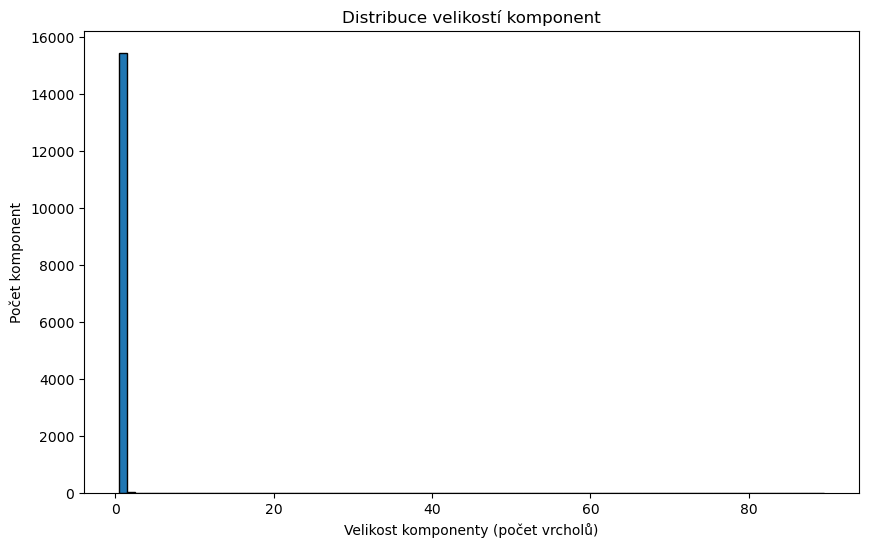

In [118]:
# Počet souvislých komponent
unique_components = df['strongcompnum'].nunique()
print(f"Počet souvislých komponent: {unique_components}")

# Distribuce velikostí komponent
component_distribution = df['strongcompnum'].value_counts()
print("Distribuce velikostí komponent:")
print(component_distribution)

plt.figure(figsize=(10, 6))
plt.hist(component_distribution, bins=range(1, component_distribution.max() + 1), edgecolor='black', align='left')
plt.title('Distribuce velikostí komponent')
plt.xlabel('Velikost komponenty (počet vrcholů)')
plt.ylabel('Počet komponent')
plt.show()
